# Biotic anthropogenic classification

Aim is to classify each moment in time as being:
    
- biotic/not biotic
- anthropogenic/not anthropogenic


We will use a separate model for each of these classifications

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections

import scipy.io.wavfile
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import collections
from scipy.ndimage.interpolation import zoom

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency


In [36]:
# getting a list of all the files
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
files = os.listdir(base_path + '/detection_challenge')
files = [xx.split('.')[0] for xx in files if 'sampled' not in xx]

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01,
    }

print len(files)

362


## Computing all the features and saving to disk

In [70]:
# for each file, compute features for each second and assign to biotic/not_biotic lists
# we will worry about anthropogenic later
max_files = 50

# maximum num slices of each class to take from each file
max_from_each_file = 500
files_to_use = files[:max_files]

features_savepath = '/home/michael/projects/engaged_hackathon_data/detection/biotic_anthrop/'


def choose_locations(idxs, maximum, balance=False):
    """
    Given a binary array, the function returns a list of positive and negative locations sampled
    at random from the list.
    Returns 'maximum' locations unless there there are fewer than maximum locations in
    idxs, in which case all are returned
    If balance is true then the classes are balanced to the smaller class size to
    ensure an equal number of each
    """
    false_idxs = np.where(idxs==0)[0]
    true_idxs = np.where(idxs==1)[0]
    
    if false_idxs.shape[0] > maximum and maximum is not None:
        false_idxs = np.random.choice(false_idxs, maximum, replace=False)
        
    if true_idxs.shape[0] > maximum and maximum is not None:
        true_idxs = np.random.choice(true_idxs, maximum, replace=False)
        
    if false_idxs.shape[0] != true_idxs.shape[0] and balance:
        raise Exception("Not implemented!")
        
    return true_idxs, false_idxs
    

def extract_1d_patches(array, locations, hww):
    """
    Extract vertical patches from the array, at the locations given.
    Each slice has a half window width hww
    
    Returns an array of shape:
    (len(locations), array.shape[0], hww*2+1)
    """
    # pad the array to account for overspill
    offset_idxs_np = np.array(locations) + hww
    extra1 = np.tile(array[:, 0], (hww, 1)).T
    extra2 = np.tile(array[:, -1], (hww, 1)).T
    a_temp = np.hstack((extra1, array, extra2))
    
    # set up the array of index locations to extract from
    idxs = [offset_idxs_np]
    for offset in range(1, hww+1):
        idxs.insert(0, offset_idxs_np-offset)
        idxs.append(offset_idxs_np+offset)
    new_idx = np.vstack(idxs).T.ravel()
    
    # extract the patches and do the appropriate reshapgin
    new_shape = (array.shape[0], offset_idxs_np.shape[0], hww*2 + 1)
    to_return = a_temp[:, new_idx].reshape(new_shape).transpose((1, 0, 2))
    return to_return

    
def extract_features(spec, binary_idxs, maximum=None):
    """
    returns a set of features from the spectrogram at points marked by idxs.
    If there are more idx locations than maximum, then will subsample idxs.
    """
    tic = time()    
    true_idxs, false_idxs = choose_locations(binary_idxs, maximum)
    idxs = np.hstack([true_idxs, false_idxs])
    labels = np.hstack(
        [np.ones(true_idxs.shape), np.zeros(false_idxs.shape)])
    N = idxs.shape[0]
    
    max_pos = np.argmax(spec[:, idxs], axis=0)[:, None]
    max_val = np.max(spec[:, idxs], axis=0)[:, None]

    substrips = extract_1d_patches(spec[:-1], idxs, 3)
    
    # do the pooling
    substrips_reshape = substrips.reshape((substrips.shape[0], -1, substrips.shape[2]*8))
    substrip_maxs = substrips_reshape.max(2).reshape((idxs.shape[0], -1))
    substrip_vars = substrips_reshape.var(2).reshape((idxs.shape[0], -1))
    substrip_means = substrips_reshape.mean(2).reshape((idxs.shape[0], -1))

    # TODO - do the sum of abs differences along the horizontal component...
    abs_diffs_sums = np.abs(np.diff(substrips, axis=2)).sum(axis=2)
    reshaped_abs_diffs = abs_diffs_sums.reshape((substrips.shape[0], -1, 8))
    pooled_abs_diffs = reshaped_abs_diffs.max(2)
    abs_diffs_range = reshaped_abs_diffs.max(2) - reshaped_abs_diffs.min(2)
    
    abs_diffs_max = np.abs(np.diff(substrips, axis=2)).max(axis=2)
    abs_diffs_max_pooled = abs_diffs_max.reshape((substrips.shape[0], -1, 8)).max(2)
    
    # now do the filter response with various gaussian filters
    filter_pooling_list = []
    for filt in engaged_features.gauss_filters_generator(spec, deviation=6):
        filt_substrips = extract_1d_patches(filt[:-1], idxs, 3)
        filt_substrips_reshape = filt_substrips.reshape(
            (filt_substrips.shape[0], -1, filt_substrips.shape[2]*16))
        filt_substrip_maxs = filt_substrips_reshape.max(2).reshape((idxs.shape[0], -1))
        filter_pooling_list.append(filt_substrip_maxs)
        
    filter_pooling = np.hstack(filter_pooling_list)
    
    return {
        'max_val': max_val,
        'max_pos': max_pos,
        'substrip_maxs': substrip_maxs,
        'substrip_vars': substrip_vars,
        'substrip_means': substrip_means,
        'pooled_abs_diffs': pooled_abs_diffs,
        'abs_diffs_range': abs_diffs_range,
        'abs_diffs_max': abs_diffs_max,
        'abs_diffs_max_pooled': abs_diffs_max_pooled,
        'num_idxs': N,
        'single_strip': spec[:, idxs].T,
        'idxs': idxs,
        'labels': labels,
        'pooled_filters': filter_pooling
    }

# max_features, med_features, max_pos,  
from time import time
def process_file(inputs):
    
    count, fname = inputs
    
    # load in wav and convert to spectrogram
    tic = time()
    sr, wav = scipy.io.wavfile.read(base_path + '/25_Random/' + fname + '.wav')  
    spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    spec -= np.median(spec, axis=1)[:, None]
#     spec[spec < 0] = 0
        
    # load in ground truth
    gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(wav.shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)
    gt_anthrop = zoom(gt['anthropogenic'][0], zoom_factor).astype(bool)
    
    # group spec slices according to labels
    these_data = {}
    
    # let's group the X here and create a suitable Y vector...
    XY = extract_features(spec, gt_biotic, max_from_each_file)
    savepath = features_savepath + fname + '_biotic.mat'
    scipy.io.savemat(savepath, XY, do_compression=True)
    
    XY = extract_features(spec, gt_anthrop, max_from_each_file)
    savepath = features_savepath + fname + '_anthrop.mat'
    scipy.io.savemat(savepath, XY, do_compression=True)

    if count % 5 == 0:
        print count,

In [66]:
if False:
    import multiprocessing
    import functools
    pool = multiprocessing.Pool(8)
    pool.map(process_file, enumerate(files_to_use))
else:
    map(process_file, enumerate(files_to_use))

# unzipping the list of tuples
# features, Y = zip(*XY)

> <ipython-input-66-cd96624de267>(93)extract_features()
-> abs_diffs_max = np.abs(np.diff(substrips, axis=2)).max(axis=2)
(Pdb) print abs_diffs_sums.shape
(1000, 512)
(Pdb) print reshaped_abs_diffs.shape
(1000, 64, 8)
(Pdb) print abs_diffs_sums[1, 0]
5.72119987282
(Pdb) print reshape_abs_diffs[1, 0, 0]
*** NameError: name 'reshape_abs_diffs' is not defined
(Pdb) print reshaped_abs_diffs[1, 0, 0]
5.72119987282
(Pdb) pdb.quit()
*** AttributeError: 'module' object has no attribute 'quit'
(Pdb) pdb.exit
*** AttributeError: 'module' object has no attribute 'exit'
(Pdb) pdb.stop()
*** AttributeError: 'module' object has no attribute 'stop'
(Pdb) q


BdbQuit: 

In [65]:
XY = scipy.io.loadmat(features_savepath + files_to_use[0] + '_biotic.mat')
for tt in XY.itervalues():
    try:
        print tt.shape
    except:
        pass

(1000, 513)
(1000, 192)
(1000, 64)
(1000, 64)
(1000, 512)
(1, 1000)
(1000, 64)
(1, 1)
(1000, 1)
(1000, 64)
(1000, 1)
(1, 1000)
(1000, 64)
(1000, 64)


In [38]:
# splitting into train and test sets
train_files, test_files = train_test_split(files_to_use, random_state=0)

## Compiling together the features for each experiment

In [39]:
class_to_use = 'biotic'

experiments = collections.OrderedDict([
    ('max_val', ['max_val']),
    ('max_pos', ['max_pos']),
    ('pooled_abs_diffs', ['pooled_abs_diffs']),
    ('abs_diffs_range', ['abs_diffs_range']),
    ('abs_diffs_max', ['abs_diffs_max']),
    ('abs_diffs_max_pooled', ['abs_diffs_max_pooled']),
    ('substrip_maxs', ['substrip_maxs']),
    ('substrip_vars', ['substrip_vars']),
    ('substrip_means', ['substrip_means']),
    ('all_single_strips', ['max_val', 'max_pos']),
    ('single_strip', ['single_strip']),
    ('all_substrips', ['substrip_maxs', 'substrip_vars', 'substrip_means']),
    ('pooled_filters', ['pooled_filters'])
        
])

train_Y = []
train_X = collections.defaultdict(list)
test_Y = []
test_X = collections.defaultdict(list)

# loop over each *file* first, this minimises I/O time
for fname in train_files:
    
    # load in the data
    these_data = scipy.io.loadmat(features_savepath + fname + '_' + class_to_use + '.mat')
    train_Y.append(these_data['labels'])
        
    for experiment_name, features in experiments.iteritems():
        temp = [these_data[feature] for feature in features]
        train_X[experiment_name].append(np.hstack(temp))

train_Y = np.hstack(train_Y).ravel()

# loop over each *file* first, this minimises I/O time
for fname in test_files:
    
    # load in the data
    these_data = scipy.io.loadmat(features_savepath + fname + '_' + class_to_use + '.mat')
    test_Y.append(these_data['labels'])
        
    for experiment_name, features in experiments.iteritems():
        temp = [these_data[feature] for feature in features]
        test_X[experiment_name].append(np.hstack(temp))

test_Y = np.hstack(test_Y).ravel()

for xx in train_X.keys():
    train_X[xx] = np.vstack(train_X[xx])
    
for xx in test_X.keys():
    test_X[xx] = np.vstack(test_X[xx])
    
# now let's balance the classes...
def balance_classes(X, Y):
    positives = np.where(Y == 0)[0]
    negatives = np.where(Y == 1)[0]
    max_examples = min(len(positives), len(negatives))
    if len(positives) > max_examples:
        positives = np.random.choice(positives, max_examples, replace=False)
    if len(negatives) > max_examples:
        negatives = np.random.choice(negatives, max_examples, replace=False)
    for key in X.keys():
        X[key] = np.vstack((X[key][negatives, :], X[key][positives, :]))
    new_Y = np.hstack((Y[negatives], Y[positives])) 
    return X, new_Y

train_X, train_Y = balance_classes(train_X, train_Y)
test_X, test_Y = balance_classes(test_X, test_Y)

# print train_Y.sum(), train_Y.shape, train_X['all_substrips'].shape
# prCenter.int test_Y.sum(), test_Y.shape, test_X['all_substrips'].shape
        


In [40]:
print test_X['pooled_filters'].shape
print 512

(4000, 192)
512


## Running each experiment with different feature sets

In [41]:
from sklearn.ensemble import RandomForestClassifier

predictions = collections.OrderedDict()
rfs = {}

for experiment_name, features in experiments.iteritems():
    
    print "Training for ", experiment_name
    
    temp_train_X = np.vstack(train_X[experiment_name])
    rf = RandomForestClassifier(n_estimators=50, n_jobs=8, max_features=None)
    rf.fit(temp_train_X, train_Y)
    
    print "Testing for ", experiment_name
    temp_test_X = np.vstack(test_X[experiment_name])
    predictions[experiment_name] = rf.predict_proba(temp_test_X)
   
    rfs[experiment_name] = rf

Training for  max_val
Testing for  max_val
Training for  max_pos
Testing for  max_pos
Training for  pooled_abs_diffs
Testing for  pooled_abs_diffs
Training for  abs_diffs_range
Testing for  abs_diffs_range
Training for  abs_diffs_max
Testing for  abs_diffs_max
Training for  abs_diffs_max_pooled
Testing for  abs_diffs_max_pooled
Training for  substrip_maxs
Testing for  substrip_maxs
Training for  substrip_vars
Testing for  substrip_vars
Training for  substrip_means
Testing for  substrip_means
Training for  all_single_strips
Testing for  all_single_strips
Training for  single_strip
Testing for  single_strip
Training for  all_substrips
Testing for  all_substrips
Training for  pooled_filters
Testing for  pooled_filters


## Viewing results

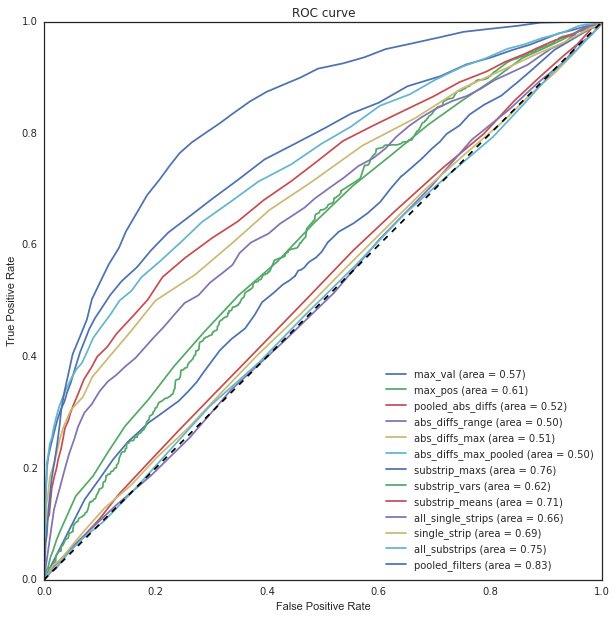

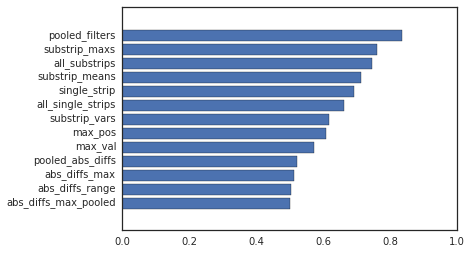

In [42]:
from sklearn.metrics import roc_curve, auc

# Potting an ROC curve for each feature set
aucs = []

plt.figure(figsize=(10, 10))
for experiment_name, pred in predictions.iteritems():
    # plotting this line
    fpr, tpr, _ = roc_curve(test_Y, pred[:, 1].ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr , label='%s (area = %0.2f)' % (experiment_name, roc_auc))
    
    # saving the auc
    aucs.append((experiment_name, roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.gca().set_aspect('equal', adjustable='box')

# Bar chart of the AUC for each feature set
plt.figure()
aucs.sort(key=lambda x: x[1])
plt.barh(np.arange(len(aucs))-0.5, [xx[1] for xx in aucs])
plt.yticks(np.arange(len(aucs)))
plt.gca().set_yticklabels([xx[0] for xx in aucs]);
plt.xlim(0, 1);

## Confusion matrix for a single feature set

[[1722  278]
 [ 930 1070]]


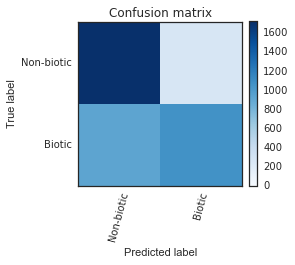

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("white")

labels = ['Non-biotic', 'Biotic']
featureset = 'substrip_maxs'

pred_Y = (predictions[featureset][:, 1]>0.5).astype(int)
cm = confusion_matrix(test_Y, pred_Y)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=75)
    
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print cm
plt.figure(figsize=(4, 4))
plot_confusion_matrix(cm);
plt.clim(0, cm.max())

## Accuracy scores for one experiment

In [44]:
from sklearn.metrics import classification_report, accuracy_score

print classification_report(test_Y, pred_Y)

print "Accuracy is ", accuracy_score(test_Y, pred_Y)

             precision    recall  f1-score   support

        0.0       0.65      0.86      0.74      2000
        1.0       0.79      0.54      0.64      2000

avg / total       0.72      0.70      0.69      4000

Accuracy is  0.698


In [45]:
print test_Y.shape, test_Y.sum()
print train_Y.shape, train_Y.sum()

(4000,) 2000.0
(14056,) 7028.0


## Predict for a single file and view the performance per slice...

In [46]:
print test_files[4]
print test_files[0]
print train_files

SW154LA-3527_20130705_0811
CR8-13548_20130919_0742
['NW1-013527_20130626_1513', 'NW1-013527_20130630_1116', 'E47EN-013527_20131013_1434', 'HA53AA-13548_20130729_1040', 'CR05EF-13527_20130918_1342', 'CR8-13548_20130919_1246', 'W84LA-013548_20130622_0433', 'E105JP-13548_20131012_2334', 'NW1-013527_20130624_1917', 'W84LA-013548_20130621_1837', 'WC2H8LG-3527_20130712_0902', 'W112NN-13548_20130709_1234', 'SW154LA-3527_20130704_2356', 'WC2H8LG-3527_20130714_0627', 'W112NN-13548_20130710_1911', 'HA86RB-13527_20130724_1723', 'RM14-3YB-944_1_20130616_160300_000', 'WC2H8LG-3527_20130710_1013', 'CR05EF-13527_20130919_1733', 'CR05EF-13527_20130916_1909', 'SE3-13548_20130910_2057', 'CR05EF-13527_20130921_0931', 'SW112PN-3527_20130821_1144', 'SE3-13548_20130912_0635', 'HA86RB-13527_20130725_0338', 'HA53AA-13548_20130727_0216', 'SE23-13527_20130907_0620', 'CR05EF-13527_20130917_1415', 'W84LA-013548_20130625_1946', 'SE3-13548_20130907_0511', 'SW154LA-3527_20130705_0934', 'SW154LA-3527_20130706_1437', 

In [89]:
fname = test_files[2]
print fname

# load in wav and convert to spectrogram
sr, wav = scipy.io.wavfile.read(base_path + '/25_Random/' + fname + '.wav')  
spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
spec -= np.median(spec, axis=1)[:, None]
spec[spec < 0] = 0

# load in ground truth
gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')

# convert the labels to the sampling rate of the spectrogram
zoom_factor = float(spec.shape[1]) / float(wav.shape[0])
gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)
print gt_biotic.shape, gt_biotic.sum()

# extract features
idxs = np.ones(gt_biotic.shape[0])
features = extract_features(spec, idxs)

SW112PN-3527_20130823_0634
(5996,) 1130


24000


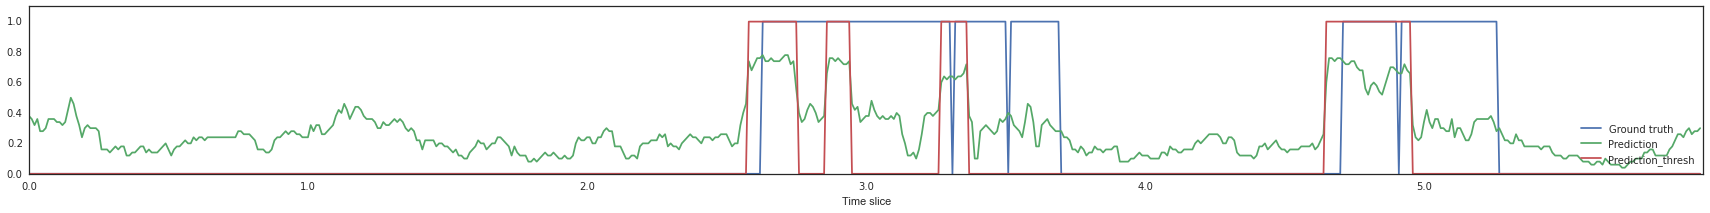

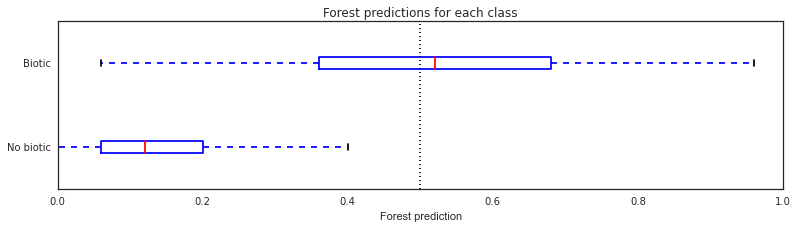

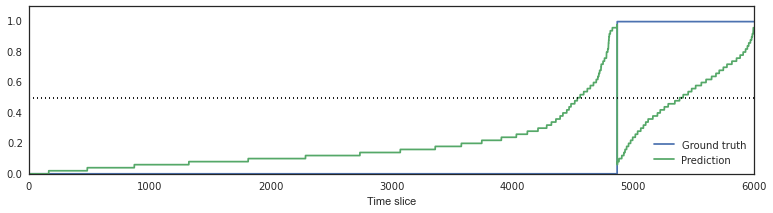

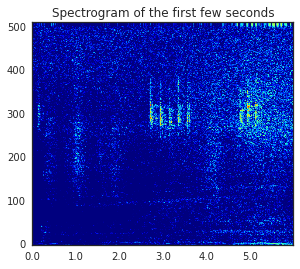

In [90]:
# run through a classifier
prediction = rfs['pooled_filters'].predict_proba(
    features['pooled_filters'])[:, 1]

# plotting the prediction as a graph
plt.figure(figsize=(30, 3))
to_plot = 600
plt.plot(gt_biotic[:to_plot], label='Ground truth')
plt.plot(prediction[:to_plot], label='Prediction')
plt.plot(prediction[:to_plot]>0.5, label='Prediction_thresh')
plt.ylim(0, 1.1)
plt.xlabel('Time slice')
plt.legend(loc="lower right")
print sr
lab_positions = np.arange(0, to_plot, spec_sample_rate)
plt.xticks(lab_positions)
plt.gca().set_xticklabels(lab_positions / spec_sample_rate)

sorted_preds = [prediction[gt_biotic==0], prediction[gt_biotic==1]]

plt.figure(figsize=(13, 3))
plt.boxplot(sorted_preds, 0, 'b+', 0);
plt.xlim(0, 1.0)
plt.xlabel('Forest prediction')
plt.title('Forest predictions for each class')
plt.plot([0.5, 0.5], [0, 3], 'k:')
plt.gca().set_yticklabels(['No biotic', 'Biotic']);

# now try the first plot but reorder the strips according to class...
# sorted_idx = np.argsort(gt_biotic)
sorted_idx = np.lexsort((prediction, gt_biotic))
plt.figure(figsize=(13, 3))
plt.plot(gt_biotic[sorted_idx], label='Ground truth')
plt.plot(prediction[sorted_idx], label='Prediction')
# plt.plot(prediction[sorted_idx]>0.5, label='Prediction_thresh')
plt.ylim(0, 1.1)
plt.xlabel('Time slice')
plt.legend(loc="lower right")
plt.plot([0, plt.gca().get_xlim()[1]], [0.5, 0.5], 'k:')


plt.figure()
plt.imshow(spec[:, :to_plot], cmap=plt.jet())
plt.gca().invert_yaxis()
plt.title('Spectrogram of the first few seconds')
plt.xticks(lab_positions)
plt.gca().set_xticklabels(lab_positions / spec_sample_rate)
plt.show()

In [49]:
# useful to see, of all the annotations in the test file, which are overall true positives etc.
# then write these to sound file so can be played...


## Training data saturation...

In [50]:
feature_to_use = 'substrip_maxs'
per_features = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
saturation_results = []
temp_train_X = np.vstack(train_X[feature_to_use])

for per_feature in per_features:

    temp_accs = []
    
    print "\nTraining for ", per_feature
    
    for _ in range(5):

        print " --- ",
        
        # randomly sample the training data
        num_to_use = int((float(per_feature)/100.0) * temp_train_X.shape[0])
        idxs = np.random.choice(temp_train_X.shape[0], num_to_use, replace=False)
        subsampled_train_X = temp_train_X[idxs, :]

        # train classifier
        rf = RandomForestClassifier(n_estimators=50, n_jobs=8, max_features=None)
        rf.fit(subsampled_train_X, train_Y[idxs])

        # predict
        temp_test_X = np.vstack(test_X[feature_to_use])
        pred_temp = rf.predict(temp_test_X)

        temp_accs.append(accuracy_score(test_Y, pred_temp))
    
    saturation_results.append(temp_accs)


Training for  10
 ---   ---   ---   ---   ---  
Training for  20
 ---   ---   ---   ---   ---  
Training for  30
 ---   ---   ---   ---   ---  
Training for  40
 ---   ---   ---   ---   ---  
Training for  50
 ---   ---   ---   ---   ---  
Training for  60
 ---   ---   ---   ---   ---  
Training for  70
 ---   ---   ---   ---   ---  
Training for  80
 ---   ---   ---   ---   ---  
Training for  90
 ---   ---   ---   ---   ---  
Training for  100
 ---   ---   ---   ---   --- 


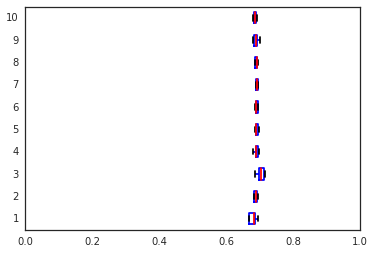

In [51]:
plt.boxplot(saturation_results, 0, 'b+', 0)
plt.xlim(0, 1)
plt.show()
# np.vstack()
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# plt.plot(per_features, saturation_results)
# ax2 = ax1.twiny()
# X2tick_location= ax1.xaxis.get_ticklocs()
# ax2.set_xticks(X2tick_location)
# ax1.set_xticklabels(per_features)
# ax2.set_xticklabels((np.array(per_features) * 0.01 * temp_train_X.shape[0]).astype(int))
# plt.show()

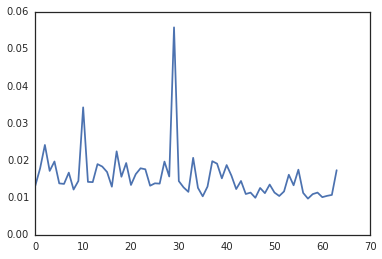

In [52]:


# plt.plot(gt_biotic, prediction, '.')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('Ground truth')
# plt.ylabel('Predictions')
# plt.title('ROC curve')

# plt.gca().set_aspect('equal', adjustable='box')



plt.plot(rf.feature_importances_)